# __Step 6 Analyses of models and predictions__

Goals: I am interested in:
- Model interpretation
  - Figure out how top words that define plant sciences are related to each other. 
  - See if there is certain date range, journal are more challenging to predict.

Main questions:
- What is the overall performance of model?
- What features are important for predictions?
- What are the reasons for mispredictions?
  - Are there any patterns among predicted instances?
  - E.g., publication date, journal.
- How are the article related to each other in the W2V space?
  - We have the vecortized document. Can plot them with tSNE to see how TP, FP, FN, and TN are distributed.

Also for interpretability purpose:
- Tf-Idf with `[max_features, ngram_range, p_threshold]=[10000.0, (1, 3), 0.01]` are also examined.
- This is because the Tf-Idf values is immediately interpretable and the model is based on XGBoost and I can get feature importance using SHAP.

## ___Setup___

### Import

In [2]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import metrics

### Configurations

In [3]:
work_dir     = Path.home() / 'projects/plant_sci_hist/2_text_classify'
corpus_combo = work_dir / "corpus_combo"
train_pred   = work_dir / "corpus_train_pred"
valid_pred   = work_dir / "corpus_valid_pred"
test_pred    = work_dir / "corpus_test_pred"

### Consolidate predictions with original dataframe

In [4]:
def json_to_df(json_file):
  with json_file.open("r+") as f:
      json_loaded = json.load(f)
  df = pd.read_json(json_loaded)
  
  return df

In [5]:
# Get the original corpus
corpus_ori = json_to_df(corpus_combo)
corpus_ori.shape

(86646, 9)

In [6]:
# Load the prediction TSV files as dataframes
train_pred_df = pd.read_csv(train_pred, sep='\t', index_col=0)
valid_pred_df = pd.read_csv(valid_pred, sep='\t', index_col=0)
test_pred_df  = pd.read_csv(test_pred , sep='\t', index_col=0)

In [7]:
train_pred_df["subset"] = "train"
valid_pred_df["subset"] = "valid"
test_pred_df["subset"]  = "test"

In [8]:
train_pred_df.sample(3)

,y,y_pred,y_prob,X,subset
822166,1,1,0.798292,priming environmental challenge proteomics pla...,train
1004565,1,1,0.987181,characterization diferuloylated pectic polysac...,train
321151,1,1,0.896067,endonuclease programmed cell death (pcd) invol...,train


In [9]:
# Make sure the indices between two dataframes are consistent
print(train_pred_df.loc[271250].X[:100])
print(corpus_ori.loc[271250].txt[:100])

nuclear pore complex nuclear pore complex largest supramolecular complex assembles eukaryotic cell s
The nuclear pore complex.. The nuclear pore complex is the largest supramolecular complex that assem


In [10]:
# Make sure the indices between two dataframes are consistent
print(train_pred_df.loc[583057].X[:100])
print(corpus_ori.loc[583057].txt[:100])

difference universal diverse orientation among nursing student australia globalization intensified m
Differences in universal diverse orientation among nursing students in Australia.. With globalizatio


In [11]:
# Concatenate prediction dataframes
pred_df = pd.concat([train_pred_df, valid_pred_df, test_pred_df])
pred_df.shape

(86646, 5)

In [12]:
pred_df.head()

,y,y_pred,y_prob,X,subset
516651,1,1,0.982180,vivo vitro inhibition catalase leaf nicotiana ...,train
521301,1,1,0.993828,pathway glucose regulation monosaccharide tran...,train
65516,0,0,0.001417,feasibility home treatment diarrhoea packaged ...,train
277058,1,1,0.990589,modulation phosphatidylcholine biosynthesis ce...,train
753225,1,1,0.921157,120yr period dr beals seed viability experimen...,train


In [13]:
# Concatenate prediction dataframe and the original dataframe
combo_pred = pd.concat([corpus_ori, pred_df], axis=1)
combo_pred.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,txt,label,txt_clean,y,y_pred,y_prob,X,subset
600447,18467466,2008-05-10,Plant physiology,The Arabidopsis halophytic relative Thellungie...,A comprehensive knowledge of mechanisms regula...,plant,The Arabidopsis halophytic relative Thellungie...,1,arabidopsis halophytic relative thellungiella ...,1,1,0.993899,arabidopsis halophytic relative thellungiella ...,train
583302,18065557,2007-12-11,Plant physiology,An Arabidopsis purple acid phosphatase with ph...,Ascorbate (AsA) is the most abundant antioxida...,plant,An Arabidopsis purple acid phosphatase with ph...,1,arabidopsis purple acid phosphatase phytase ac...,1,1,0.995514,arabidopsis purple acid phosphatase phytase ac...,train


In [14]:
# Check the label and y columns again to make sure they are exactly the same
combo_pred['label'].equals(combo_pred['y'])

True

In [15]:
# Drop the uncessary columns
combo_pred = combo_pred.drop(['txt', 'txt_clean', 'y', 'X'], axis=1)
combo_pred.head(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,label,y_pred,y_prob,subset
600447,18467466,2008-05-10,Plant physiology,The Arabidopsis halophytic relative Thellungie...,A comprehensive knowledge of mechanisms regula...,plant,1,1,0.993899,train
583302,18065557,2007-12-11,Plant physiology,An Arabidopsis purple acid phosphatase with ph...,Ascorbate (AsA) is the most abundant antioxida...,plant,1,1,0.995514,train


In [16]:
combo_pred_json = combo_pred.to_json()
combo_pred_json_file = work_dir / 'corpus_combo_pred.json'
with combo_pred_json_file.open("w+") as f:
  json.dump(combo_pred_json, f)

## ___Mis-predictions___

### Get confusion matrix

Confusion matrix:
- tn: 41327
- fp: 1996
- fn: 888
- tp: 42435

In [17]:
def get_confusion_matrix(df, subset=""):
  if subset == "":
    y_true = df['label'].values
    y_pred = df['y_pred'].values
  else:
    y_true = df[df['subset'] == subset]['label'].values
    y_pred = df[df['subset'] == subset]['y_pred'].values

  tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred).ravel()

  print("number of instances:", sum([tn, fp, fn, tp]))

  return tn, fp, fn, tp

In [18]:
# overall tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="")

number of instances: 86646


(41327, 1996, 888, 42435)

In [19]:
# validation tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="valid")

number of instances: 17329


(8244, 420, 209, 8456)

In [20]:
# testing tn, fp, fn, tp
get_confusion_matrix(combo_pred, subset="test")

number of instances: 17330


(8211, 454, 228, 8437)

### Add an incorrect column and get all the wrongly predicted entries

This turn out not to be useful, yet.

In [21]:
incorrect = [val_l[i] != val_y[i] for i in range(len(val_l)) ]

NameError: name 'val_l' is not defined

In [ ]:
combo_pred['incorrect'] = incorrect
combo_pred.shape

(86646, 11)

In [ ]:
combo_pred_wrong = combo_pred[incorrect]
combo_pred_wrong.shape

(2884, 11)

In [ ]:
combo_pred_wrong.sample(2)

,PMID,Date,Journal,Title,Abstract,QualifiedName,label,y_pred,y_prob,subset,incorrect
5116,173636,1975-01-01,Folia histochemica et cytochemica,Oxidative enzymes in the development of Fascio...,The object of the study was the investigation ...,hepatica,0,1,0.822273,valid,True
14963,605710,1977-01-01,Acta biologica Academiae Scientiarum Hungaricae,Changes in chromosome complement in long-term ...,A prolonged callus culture from pea (Pisum sat...,pea,0,1,0.706658,train,True
881237,24018323,2013-09-11,Advances in protein chemistry and structural b...,Structure-function relationship of the plant p...,"LHCII, the largest plant photosynthetic pigmen...",plant,0,1,0.937996,train,True
1177809,28943973,2017-09-26,Journal of genomics,Permanent Draft Genome sequence for Frankia sp...,Frankia sp. strain CcI49 was isolated from Cas...,plants,0,1,0.842421,test,True
63001,2154301,1990-01-01,Cell differentiation and development : the off...,Is ubiquitin involved in the dedifferentiation...,Transformation of a mesophyll cell into a viab...,plant,0,1,0.979742,train,True
1132663,28286876,2017-03-14,Current opinion in toxicology,Diversity as Opportunity: Insights from 600 Mi...,The aryl hydrocarbon receptor (AHR) was for ma...,anemone,0,1,0.705611,valid,True
717363,20948627,2009-01-01,F1000 biology reports,The dark side of clock-controlled flowering.,Perception of seasonal changes in day length a...,plants,0,1,0.604388,train,True
1086049,27398266,2014-12-01,Journal of geophysical research. Biogeosciences,Models of fluorescence and photosynthesis for ...,We have extended a conventional photosynthesis...,plants,0,1,0.984490,train,True
1042548,26632529,2015-12-04,Phytochemistry,"Differentiation between two ""fang ji"" herbal m...","Stephania tetrandra (""hang fang ji"") and Arist...",plant,1,0,0.191211,valid,True
919443,24504833,1969-03-01,Planta,Second positive phototropic response patterns ...,"1.During second positive irradiation, bending ...",oat,1,0,0.458158,valid,True


### Get prediction probability distributions of tp, tn, fp, fn

In [ ]:
c_true = combo_pred['label']  # column for true label
c_pred = combo_pred['y_pred'] # column for predicted label
subset = combo_pred['subset'] # column with subset info
combo_test_tp = combo_pred[(c_true == 1) & (c_pred == 1) & (subset == "test")]
combo_test_tp.shape # Expected 8437 instances

(8437, 10)

In [ ]:
combo_test_tn = combo_pred[(c_true == 0) & (c_pred == 0) & (subset == "test")]
combo_test_fp = combo_pred[(c_true == 0) & (c_pred == 1) & (subset == "test")]
combo_test_fn = combo_pred[(c_true == 1) & (c_pred == 0) & (subset == "test")]
# Expected tn=8211, fp=454, fn=228
combo_test_tn.shape, combo_test_fp.shape, combo_test_fn.shape

((8211, 10), (454, 10), (228, 10))

<AxesSubplot:ylabel='Density'>

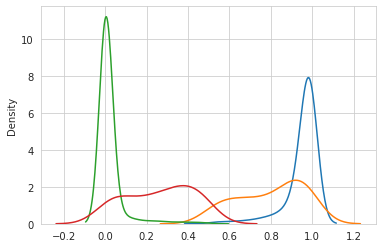

In [ ]:
sns.set_style('whitegrid')
sns.kdeplot(np.array(combo_test_tp["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_fp["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_tn["y_prob"]), bw_method=0.5)
sns.kdeplot(np.array(combo_test_fn["y_prob"]), bw_method=0.5)

Problem with the above plot is that the distributions are fitted and value ranges are not correct.

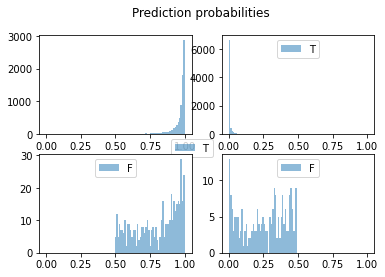

In [ ]:
fig, axs = plt.subplots(2, 2)
bins = np.linspace(0, 1, 100)
fig.suptitle('Prediction probabilities')
axs[0,0].hist(combo_test_tp["y_prob"], bins, alpha=0.5)
axs[0,0].legend("TP", loc="upper center")
axs[0,1].hist(combo_test_tn["y_prob"], bins, alpha=0.5)
axs[0,1].legend("TN ", loc="upper center")
axs[1,0].hist(combo_test_fp["y_prob"], bins, alpha=0.5)
axs[1,0].legend("FP ", loc="upper center")
axs[1,1].hist(combo_test_fn["y_prob"], bins, alpha=0.5)
axs[1,1].legend("FN ", loc="upper center")
plt.show()

... Can do better.

In [ ]:
# Add another column, labeling TP, FP, TN, FN
true_vs_pred = []
for i in range(len(c_true)):
  if c_true.iloc[i] == 1 and c_pred.iloc[i] == 1:
    true_vs_pred.append("TP")
  elif c_true.iloc[i] == 1 and c_pred.iloc[i] == 0:
    true_vs_pred.append("FN")
  elif c_true.iloc[i] == 0 and c_pred.iloc[i] == 0:
    true_vs_pred.append("TN")
  elif c_true.iloc[i] == 0 and c_pred.iloc[i] == 1:
    true_vs_pred.append("FP")
  else:
    print("This should not happen...")

In [ ]:
combo_pred["true_vs_pred"] = true_vs_pred

<AxesSubplot:xlabel='y_prob', ylabel='Density'>

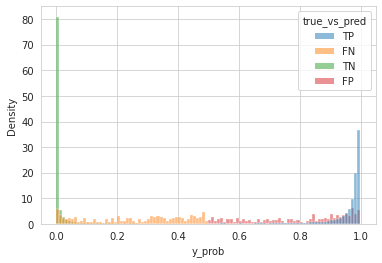

In [ ]:
sns.histplot(data=combo_pred[combo_pred["subset"] == "test"],
             x="y_prob", 
             hue="true_vs_pred",
             stat="density",
             common_norm=False,
             bins=100, alpha=0.5)

In [1]:
test_pos = combo_pred[(combo_pred["subset"] == "test") &
                      (combo_pred["true_vs_pred"] == "TP") &
                      (combo_pred["true_vs_pred"] == "FN")]

sns.histplot(data=test_pos,
             x="y_prob", 
             hue="true_vs_pred",
             bins=100, alpha=0.5)

NameError: name 'combo_pred' is not defined